# PS 3 - OLG

## 2.1

In [1]:
import numpy as np
import matplotlib as plt

In [2]:
#Calibration

beta_ss = 0.442
delta_ss = 0.6415
sigma_ss = 3
A_ss = 1
alpha_ss = 0.35
L_ss = 2.2

f_params_21 = (L_ss, A_ss, alpha_ss, delta_ss)
eul_args_22 = (beta_ss, sigma_ss, L_ss, A_ss, alpha_ss, delta_ss)

In [3]:
def wage_ss(args_w, bvec_guess):
    L, A, alpha = args_w
    K = bvec_guess.sum()
    w = (1-alpha)*A*(K/L)**alpha
    return w

def r_ss(args_k, bvec_guess):
    L, A, alpha, delta = args_k
    K = bvec_guess.sum()
    r = alpha*A*(L/K)**(1-alpha) - delta
    return r

In [4]:
def feasible(f_params, bvec_guess):
    
    L, A, alpha, delta = f_params
        
    #Consumption block
    
    c_cnstr = np.zeros(3)
    c_1_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[0]
    c_2_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[1] + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[0]
    c_3_ss = 0.2*wage_ss([L, A, alpha], bvec_guess) + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[1]
    c_cnstr = np.zeros((3))
    
    if c_1_ss <= 0:
        c_cnstr[0] = True
    else:
        c_cnstr[0] = False
    
    if c_2_ss <= 0:
        c_cnstr[1] = True
    else:
        c_cnstr[1] = False
    
    if c_3_ss <= 0:
        c_cnstr[2] = True
    else:
        c_cnstr[2] = False
    
    #Capital block
    
    K_cnstr = np.zeros(1)
    if bvec_guess.sum() <= 0:
        K_cnstr[0] = True
    else:
        K_cnstr[0] = False
    
    #B block
    
    b_cnstr = np.zeros(2)
    
    if c_cnstr[0] == True:
        b_cnstr[0] = True
        b_cnstr[1] = False
    
    if c_cnstr[1] == True:
        b_cnstr[0] = True
        b_cnstr[1] = True
    
    if c_cnstr[2] == True:
        b_cnstr[0] = False
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

In [5]:
bvec_guess_1 = np.array([1.0, 1.2])
output_a = feasible(f_params_21, bvec_guess_1)

bvec_guess_2 = np.array([0.06, -0.001])
output_b = feasible(f_params_21, bvec_guess_2)

bvec_guess_3 = np.array([0.1, 0.1])
output_c = feasible(f_params_21, bvec_guess_3)

print(output_a)
print(output_b)
print(output_c)

(array([1., 0.]), array([1., 0., 0.]), array([0.]))
(array([0., 0.]), array([0., 0., 0.]), array([0.]))
(array([0., 0.]), array([0., 0., 0.]), array([0.]))


## 2.2

In [6]:
def Eul_error(bvec_guess, eul_args):
    beta, sigma, L, A, alpha, delta = eul_args
    
    EulErr_ss = np.zeros(2) #intialise vector
    
    c_1_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[0]
    c_2_ss = wage_ss([L, A, alpha], bvec_guess) - bvec_guess[1] + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[0]
    c_3_ss = 0.2*wage_ss([L, A, alpha], bvec_guess) + (1+r_ss([L, A, alpha, delta], bvec_guess))*bvec_guess[1]
    
    if c_1_ss <= 1e-6:
        Uprime_1 = 1e8
    else:
        Uprime_1 = c_1_ss**(-sigma)
    
    if c_2_ss <= 1e-6:
        Uprime_2 = 1e8
    else:
        Uprime_2 = c_2_ss**(-sigma)
        
    if c_1_ss <= 1e-6:
        Uprime_3 = 1e8
    else:
        Uprime_3 = c_3_ss**(-sigma)

    EulErr_ss[0] = beta*(1+r_ss([L, A, alpha, delta], bvec_guess))*Uprime_2 - Uprime_1
    EulErr_ss[1] = beta*(1+r_ss([L, A, alpha, delta], bvec_guess))*Uprime_3 - Uprime_2
    
    return EulErr_ss

In [7]:
import time
import scipy.optimize as opt
from matplotlib import pyplot as plt

def get_ss(params, bvec_guess, ss_graphs):
    beta, sigma, L, A, alpha, delta, ss_tol = params
    start_time = time.clock()
    
    root =  opt.root(Eul_error, bvec_guess, [beta, sigma, L, A, alpha, delta], tol=ss_tol)
    
    #Now find all values based on roots
    
    bvec = root.x
    b_ss = bvec
    
    w_ss = wage_ss([L, A, alpha], bvec)
    rate_ss = r_ss([L, A, alpha, delta], bvec)
    
    c_ss = np.zeros(3)
    
    c_ss[0] = w_ss - bvec[0]
    c_ss[1] = w_ss - bvec[1] + (1+rate_ss)*bvec[0]
    c_ss[2] = 0.2*w_ss + (1+rate_ss)*bvec[1]
    
    K_ss = bvec.sum()
    Y_ss = A*(K_ss**alpha)*L**(1-alpha)
    C_ss = c_ss.sum()
    R_Cerr_ss = Y_ss - C_ss- delta*K_ss
    
    EulErr_ss = Eul_error(bvec, [beta, sigma, L, A, alpha, delta])
    
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('tab20b')
    if ss_graphs == True:
        plt.bar(['c_1_ss', 'c_2_ss', 'c_3_ss'], c_ss, color = palette(3))
        plt.xlabel('Cohort')
        plt.ylabel('Consumption')
        plt.show()
    
    ss_time = time.clock() - start_time
    
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'rate_ss': rate_ss,
                 'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                 'EulErr_ss': EulErr_ss, 'RCerr_ss': R_Cerr_ss,
                 'ss_time': ss_time}

    return ss_output

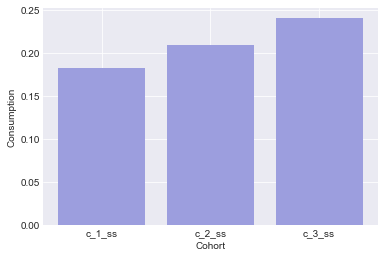

{'b_ss': array([0.01931262, 0.05841243]),
 'c_ss': array([0.18241333, 0.20961424, 0.24087656]),
 'w_ss': 0.20172594930954846,
 'rate_ss': 2.4330257711489436,
 'K_ss': 0.07772504796371657,
 'Y_ss': 0.682764751509241,
 'C_ss': 0.6329041332405168,
 'EulErr_ss': array([ 0.00253831, -0.0054862 ]),
 'RCerr_ss': 5.551115123125783e-17,
 'ss_time': 0.3907520812633206}

In [8]:
params_23 = beta_ss, sigma_ss, L_ss, A_ss, alpha_ss, delta_ss, 0.001

output = get_ss(params_23, bvec_guess_3, True)
output

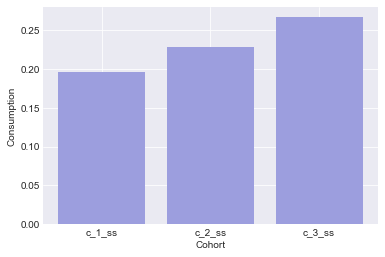

{'b_ss': array([0.02817716, 0.07686583]),
 'c_ss': array([0.1959755 , 0.22861645, 0.26669351]),
 'w_ss': 0.22415265671589663,
 'rate_ss': 1.8863668551735306,
 'K_ss': 0.10504298717498473,
 'Y_ss': 0.7586705304230349,
 'C_ss': 0.6912854541502821,
 'EulErr_ss': array([-0.00087544, -0.00013795]),
 'RCerr_ss': 1.1102230246251565e-16,
 'ss_time': 0.13963659360089276}

In [9]:
#Suppose beta rises

beta_new = 0.55

params_24 = beta_new, sigma_ss, L_ss, A_ss, alpha_ss, delta_ss, 0.001
output_2 = get_ss(params_24, bvec_guess_3, True)
output_2

## 2.3

In [10]:
#Some more parameterisation
T = 20
path_toler = 1e-9
xi = 0.2
L = 2.2
A = 1
beta = 0.442
delta = 0.6415
sigma = 3
A = 1
alpha = 0.35
n_vec = np.array([1.0, 1.0, 0.2])

In [11]:
#Steady state b's
bbar = output['b_ss']
bbar2 = bbar[0]
bbar3 = bbar[1]

In [12]:
#Initial b's
b21 = 0.8*bbar2
b31 = 1.1*bbar3

In [13]:
#Guess path for K
K1 = b21 + b31
Kbar = bbar2 + bbar3
Kpath = np.linspace(K1, Kbar, T)
Kpath = np.append(Kpath, np.array([[Kbar],[Kbar],[Kbar], [Kbar], [Kbar]]))

In [14]:
#Create the initial rpaths and wpaths

Wpath = ((1-alpha)*A/(L**alpha))*Kpath**alpha
Rpath = alpha*A*(L/Kpath)**(1-alpha) - delta

In [15]:
#Get the older generations b3 in time period 2
from matplotlib import pyplot as plt
import scipy.optimize as opt

def get_a_life_err(b32, b32args): 
    rpath, wpath, beta, sigma = b32args
    error = ((1+rpath[0])*b21 + wpath[0] - b32)**(-sigma) - beta*(1+rpath[1])*((1+rpath[1])*b32 + wpath[1]*0.2)**(-sigma)
    return error
    

def get_a_life(rpath, wpath, beta, sigma, b32):
    root =  opt.root(get_a_life_err, b32, [rpath, wpath, beta, sigma], tol=1e-8)  
    b32_p = root.x
    return b32_p

In [16]:
b32_first = get_a_life(Rpath, Wpath, beta, sigma, 0.18)
b32_first

array([0.05560851])

In [43]:
def Eul_error_tp(b, eul_tp_args):
    beta, sigma, w1, w2, w3, r1, r2, r3 = eul_tp_args
    
    #b = [b21, b32]
    EulErr_tp = np.zeros(2) #intialise vector
    
    c_1_tp = w1 - b[0]
    c_2_tp = w2 - b[1] + (1+r2)*b[0]
    c_3_tp = 0.2*w3 + (1+r3)*b[1]
    
    if c_1_tp <= 1e-22:
        Uprime_1 = 1e8
    else:
        Uprime_1 = c_1_tp**(-sigma)
    
    if c_2_tp <= 1e-22:
        Uprime_2 = 1e8
    else:
        Uprime_2 = c_2_tp**(-sigma)
        
    if c_1_tp <= 1e-22:
        Uprime_3 = 1e8
    else:
        Uprime_3 = c_3_tp**(-sigma)

    EulErr_tp[0] = beta*(1+r2)*Uprime_2 - Uprime_1
    EulErr_tp[1] = beta*(1+r3)*Uprime_3 - Uprime_2
    
    return EulErr_tp

In [44]:
#Function that gives entire time path of b's given a guess at Kpath
def get_some_lives(bvec_tp, rpath, wpath, beta, sigma):
    
    init_b_mat = np.zeros((len(Kpath), 2))
    init_b_mat[0,:] = bvec_tp
    
    
    for i in range(T):
        root = opt.root(Eul_error_tp, bvec_tp, [beta, sigma, wpath[i], wpath[i+1], wpath[i+2], rpath[i], rpath[i+1], rpath[i+2]], tol=1e-8)
        b_result = root.x
        init_b_mat[i, 0] = b_result[0]
        init_b_mat[i+1, 1] = b_result[1]
    
    return init_b_mat


In [45]:
#Now lets find the time path

def solve():
    b_guess = np.array([0.02, 0.02]) #some initial guess for optimizer to use
    b32_first = get_a_life(Rpath, Wpath, beta, sigma, 0.18) #First guess at b32

    iters = 0
    dist = 0.1
    tptol = 1e-8

    Rpath_1 = Rpath.copy()
    Wpath_1 = Wpath.copy()
    Kpath_1 = Kpath.copy()
    
    Kprimepath = Kpath.copy()
    
    while iters < 500 and dist > tptol:
        b_mat = get_some_lives(b_guess, Rpath_1, Wpath_1, beta, sigma)
        b32_first = get_a_life(Rpath_1, Wpath_1, beta, sigma, 0.18)
        b_mat[0, 1] = b32_first #fill hole at top right
        temp = Kpath.copy()
        temp = b_mat.sum(axis = 1)
        Kprimepath[1:T+1] = temp[0:T]
        dist = ((Kprimepath - Kpath_1)**2).sum()
        Kpathnew = xi * Kprimepath + (1-xi)*Kpath_1
    
        Kpath_1 = Kpathnew
        Wpath_1 = ((1-alpha)*A/(L**alpha))*Kpathnew**alpha
        Rpath_1 = alpha*A*(L/Kpathnew)**(1-alpha) - delta
        iters += 1
        
    print(iters)
    print(dist)
    return Kprimepath, b_mat

In [46]:
TimePath, b_final = solve()

30
8.517134272839238e-09


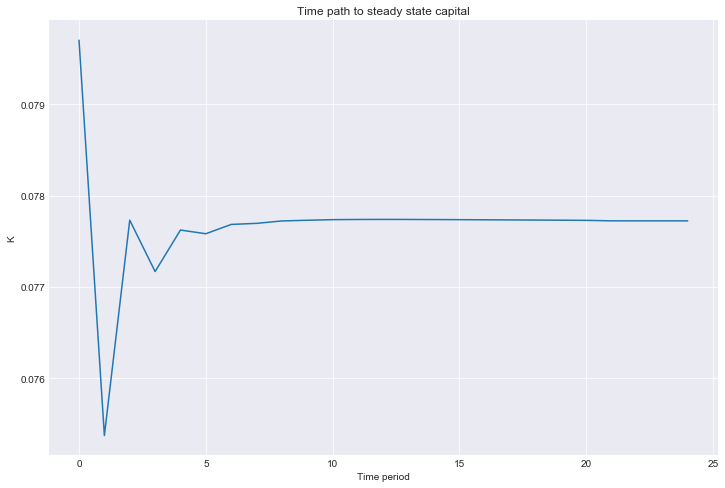

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(TimePath)
plt.xlabel('Time period')
plt.ylabel('K')
plt.title('Time path to steady state capital')
plt.show()

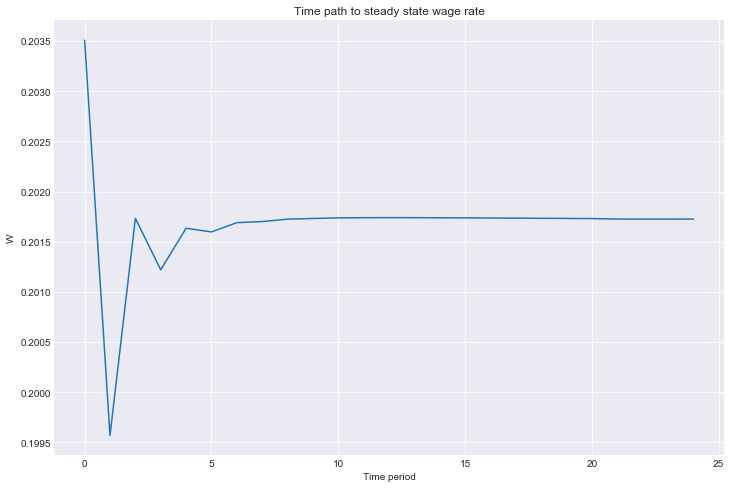

In [58]:
Wpath_fin = ((1-alpha)*A/(L**alpha))*TimePath**alpha
Rpath_fin = alpha*A*(L/TimePath)**(1-alpha) - delta

plt.figure(figsize=(12, 8))
plt.plot(Wpath_fin)
plt.xlabel('Time period')
plt.ylabel('W')
plt.title('Time path to steady state wage rate')
plt.show()

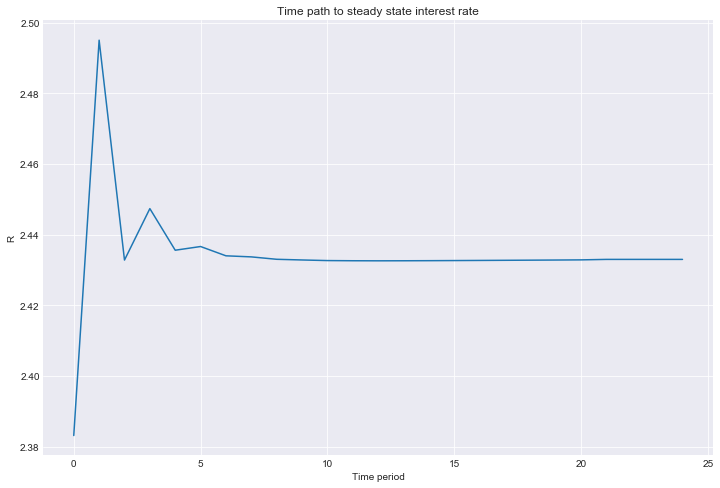

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(Rpath_fin)
plt.xlabel('Time period')
plt.ylabel('R')
plt.title('Time path to steady state interest rate')
plt.show()

In [48]:
#Modify the array of b's such that it includes the first period and steady state

borrowing = np.zeros((25,2)) #initialise matrix
borrowing[1:24, :] = b_final[0:23, :]
borrowing[0, 0] = b21
borrowing[0, 1] = b31
borrowing[21, 0] = bbar2
borrowing[21, 1] = bbar3
borrowing[22, 0] = bbar2
borrowing[22, 1] = bbar3
borrowing[23, 0] = bbar2
borrowing[23, 1] = bbar3
borrowing[24, 0] = bbar2
borrowing[24, 1] = bbar3

In [49]:
borrowing

array([[0.0154501 , 0.06425367],
       [0.02038112, 0.05499231],
       [0.01862154, 0.05911087],
       [0.01943406, 0.05773556],
       [0.01917454, 0.0584497 ],
       [0.01931594, 0.05826772],
       [0.01928368, 0.05840196],
       [0.01931084, 0.05838661],
       [0.01930897, 0.05841499],
       [0.01931476, 0.05841665],
       [0.0193153 , 0.05842276],
       [0.01931644, 0.05842352],
       [0.01931652, 0.05842417],
       [0.01931653, 0.05842365],
       [0.01931631, 0.0584229 ],
       [0.01931605, 0.05842188],
       [0.01931573, 0.05842079],
       [0.01931541, 0.05841965],
       [0.01931508, 0.05841849],
       [0.01931473, 0.05841733],
       [0.01931418, 0.05841613],
       [0.01931262, 0.05841243],
       [0.01931262, 0.05841243],
       [0.01931262, 0.05841243],
       [0.01931262, 0.05841243]])

In [50]:
#Find euler errors along time path

#Get final paths of W and R
Wpath_fin = ((1-alpha)*A/(L**alpha))*TimePath**alpha
Rpath_fin = alpha*A*(L/TimePath)**(1-alpha) - delta


Error_fin = np.zeros((30,2))
for i in range(0,15):
    q = np.array([borrowing[i, 0], borrowing[i+1, 1]])
    W1 = Wpath_fin[i]
    W2 = Wpath_fin[i+1]
    W3 = Wpath_fin[i+2]
    R1 = Rpath_fin[i]
    R2 = Rpath_fin[i]
    R3 = Rpath_fin[i+1]
    Error_fin[i, :] = Eul_error_tp(q, [beta, sigma, W1, W2, W3, R1, R2, R3])


array([[ 4.56929933e+01, -8.26283907e+00],
       [-1.58617905e+01,  3.28751232e+00],
       [ 7.17976787e+00, -9.70797219e-01],
       [-2.35492595e+00,  6.10379923e-01],
       [ 1.21958268e+00, -1.30964944e-01],
       [-3.13520812e-01,  8.95040646e-02],
       [ 2.19166246e-01, -4.18235532e-02],
       [-3.61087374e-02, -1.39528656e-02],
       [ 3.57285281e-02, -3.67788334e-02],
       [-8.80170450e-03, -3.24506836e-02],
       [-9.79007482e-04, -3.45944049e-02],
       [-8.75971901e-03, -3.19651918e-02],
       [-8.03129098e-03, -2.99578359e-02],
       [-9.04566645e-03, -2.71004441e-02],
       [-8.67912928e-03, -2.42535165e-02],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.

In [52]:
print('Max Euler error', np.max(Error_fin))

Max Euler error 45.692993345329995


In [65]:
#Distance to steady state

Difference = TimePath - Kbar
loc = np.where(np.abs(Difference) < 0.00001)
loc
#Within 0.00001 in the second 3rd period, never further than 0.00001 after the 19th period

(array([ 2,  8,  9, 18, 19, 20, 21, 22, 23, 24], dtype=int64),)